# Model Validation - RLU Regression

This notebook aims to test the developed model using the test set provided.

In [1]:
# imports
import os
import sys
import warnings
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ignore warnings
warnings.filterwarnings('ignore')

# append additional models
sys.path.append('../../modules')
from utils.ml_utils import MLutils

# constant definition
DATASOURCE = '../../data/1_raw'
DATANAME = 'PM_test.txt'
best_model_id = 'af3ab3c7d28d4539824bec6088ed9331'  # obtained from mlflow ui
MODEL_PATH = '../../models/mlruns/1/'

# list of real columns names (provided by project description) 
real_cols = [
    'asset_id',
    'runtime',
    'set1',
    'set2',
    'set3',
]

for i in range(1, 22):
    real_cols.append(f'tag{i}')

# create class instance
mlu = MLutils()

## Load data and make feature engineering

In this step, all the data preparations and cleaning done for the train set must be repeated for the test test. Only the calculation of RLU must use the maximum RLU observed in train set, to avoid information leakage.

In [2]:
# load train set to perform feature engineering
data_train = pd.read_csv(os.path.join(DATASOURCE, 'PM_train.txt'), header=None, sep=' ')

data_train.drop([26,27], axis=1, inplace=True)

# change the columns names
data_train.columns = real_cols

# check the maximum runtime for each asset_id
time_per_asset = pd.DataFrame(data_train.groupby(['asset_id'])['runtime'].max().values,
                              columns=['max_runtime'],
                              index=data_train.groupby(['asset_id'])['runtime'].max().index)

In [3]:
# load the test set
data_test = pd.read_csv(os.path.join(DATASOURCE, DATANAME), header=None, sep=' ')
data_test.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [4]:
# there are two additional columns (26 and 27) with NaNs values
# remove those
data_test.drop([26,27], axis=1, inplace=True)

# change the columns names
data_test.columns = real_cols
data_test.head()

,asset_id,runtime,set1,set2,set3,tag1,tag2,tag3,tag4,tag5,...,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [5]:
# make feature engineering
# iterate through each asset id and calculate the RLU
data_test['rlu'] = 0
for id in time_per_asset.index:
    
    # extract maximum runtime
    max_runtime = time_per_asset.loc[id, 'max_runtime']

    # calculate rlu
    data_test.loc[data_test.asset_id==id,'rlu'] = max_runtime - data_test.loc[data_test.asset_id==id, 'runtime']

data_test.head()

,asset_id,runtime,set1,set2,set3,tag1,tag2,tag3,tag4,tag5,...,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,rlu
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,191
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,190
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,189
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,188
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,187


## Model Load

The model is loaded by using the best id found when inspecting the `mlflow ui` for the regression models.

In [6]:
# load best model
model_full_path = os.path.join(MODEL_PATH, best_model_id, 'artifacts', 'model', 'model.pkl')
model = pickle.load(open(model_full_path, 'rb'))

In [7]:
# load the best model inputs
inputs_full_path = os.path.join(MODEL_PATH, best_model_id, 'artifacts', 'model', 'input_example.json')
inputs = json.load(open(inputs_full_path, 'r'))['columns']

## Make predictions on the test set

In this step, the best model found is used to make the predictions on the test set.

In [9]:
# make the predictions
yhat = model.predict(data_test[inputs])

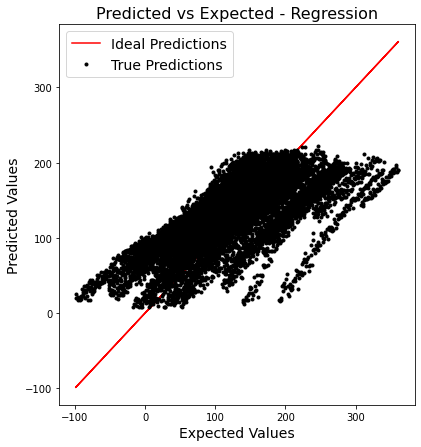

In [10]:
# validate model
fig = mlu.regression_performance_fig(data_test['rlu'], yhat)
fig.show()

In [11]:
# calculate the metrics
mae, r2 = mlu.calculate_regression_metrics(data_test['rlu'], yhat)

print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 38.634001589597794
R2 Score: 0.5061436238988124


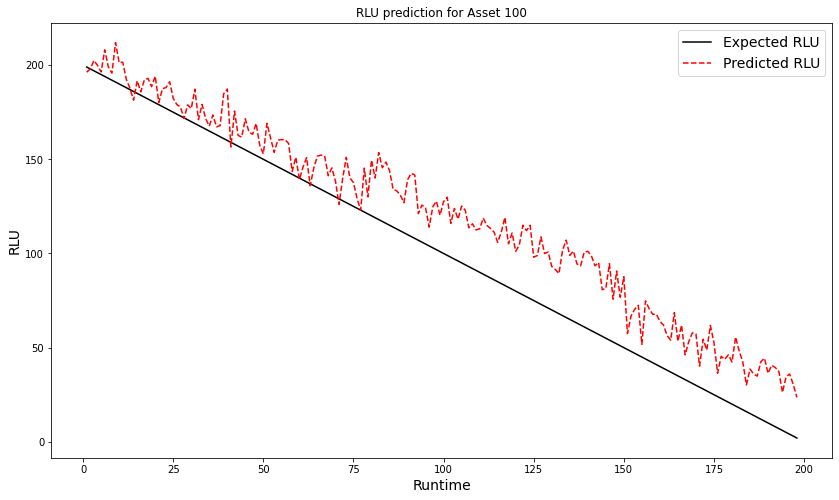

In [15]:
# final validation
data_test['rlu_pred'] = yhat

ASSET = 100

plt.figure(figsize=(14,8))
plt.plot(data_test.loc[data_test.asset_id==ASSET, 'runtime'], data_test.loc[data_test.asset_id==ASSET, 'rlu'],
         'k-', label='Expected RLU')
plt.plot(data_test.loc[data_test.asset_id==ASSET, 'runtime'], data_test.loc[data_test.asset_id==ASSET, 'rlu_pred'],
         'r--', label='Predicted RLU')
plt.xlabel('Runtime', size = 14)
plt.ylabel('RLU', size=14)
plt.legend(loc='best', prop={'size': 14})
plt.title(f'RLU prediction for Asset {ASSET}')
plt.show()

It be can be verified that the model presents significant level of variance, even showin the same trend as the test set. Comparing the metrics observed for the test set against those observed in train set (MAE = 20.55 and $R^2$ = 0.814), it can be concluded that the model is overfitted.

A possible explanation is that there is too much noise in the data from differents assets with the same runtime point. Maybe it is worth trying to group values of sensors which are close to each other, for a specific runtime. This could help to reduce noise and variance, and thus, increase model generalization.

With this model, it is expected an average prediction error of 38 cycles, which corresponds to about 20 % of the average failure runtime.

## Feature Importance Analysis

This last step will look into the model feature importance in order to take insights about the failure condition.

In [13]:
# extract feature importances
feat_imp = pd.DataFrame(model['model'].feature_importances_, columns=['importance'])
feat_imp.loc[14, 'importance'] = 0          # since all values of importances sum up to 1, the last must be zero
feat_imp['features'] = inputs 

feat_imp = feat_imp.sort_values(by=['importance'])

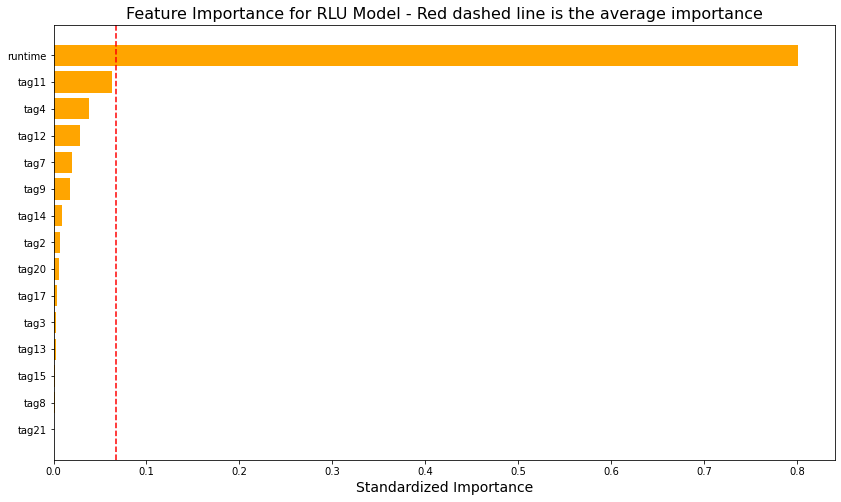

In [14]:
# make a barplot to illustrate the findings
plt.figure(figsize=(14,8))
plt.barh(y=feat_imp['features'], width=feat_imp['importance'], color='orange')
plt.axvline(x=feat_imp.importance.mean(), ls = '--', color='red')
plt.xlabel('Standardized Importance', size=14)
plt.title('Feature Importance for RLU Model - Red dashed line is the average importance', size=16)
plt.show()

The most importance feature that must be taken care of is the asset runtime. The model gave an important weight for this feature. The top 3 important features to be monitored are `tag11` and `tag4`. According to exploratory data analysis, both tags present the trend to increase when the asset is close to the failure.

Hence, the model could be used further to test performance, by manually removing least important features. It seems that the `RFECV` alone was not so effective in this case.

An example of model application is to build control charts for runtime and the important tags, and raise alarms when they achieve dangerous limits, specially when the asset presents more than 150 cycles - which, by accounting the mean erros, is almost the average maximum runtime of all assets.